In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/profiles.csv")

## Remove unneeded variables

First, let's drop all the columns we won't use.

In [3]:
df.drop(['last_online', 'location', 'sign', 'speaks', "ethnicity"], axis=1, inplace=True)
df.drop([f"essay{n}" for n in np.arange(0,10)], axis=1, inplace=True)

## Refactor "diet" variable

The "diet" variable has 6 possible cuisines (anything, vegetarian, vegan, kosher, halal, and other) and 2 changers (mostly/strictly), which might create unnecessary dummy variables that won't add value to the model. So let's boil it down to diet type without the nuance.

In [4]:
df.dropna(axis=0, subset=['diet'], inplace=True)
df['vegetarian'] = df['diet'].apply(lambda x: 1 if ("vegetarian" in x) or ("vegan" in x) else 0)
df.drop("diet", axis=1, inplace=True)

## Convert "drink" values into a numerical scale

In [5]:
df["heavy_drinker"] = df['drinks'].apply(lambda x: 1 if (x=="very often") or (x=="desperately") else 0)
df.drop("drinks", axis=1, inplace=True)

In [6]:
df["drug_user"] = df['drugs'].apply(lambda x: 1 if (x=="often") else 0)
df.drop("drugs", axis=1, inplace=True)

## Extract offspring

In [7]:
df['offspring'].replace(['doesn&rsquo;t have kids',
                         'doesn&rsquo;t have kids, and doesn&rsquo;t want any',
                         'doesn&rsquo;t have kids, but might want them',
                         'doesn&rsquo;t have kids, but wants them',
                         'might want kids',
                         'doesn&rsquo;t want kids',
                         'wants kids'], 0, inplace=True)

df['offspring'].replace(['has a kid',
                         'has a kid, and might want more',
                         'has a kid, and wants more',
                         'has a kid, but doesn&rsquo;t want more',
                         'has kids',
                         'has kids, and might want more',
                         'has kids, and wants more',
                         'has kids, but doesn&rsquo;t want more',], 1, inplace=True)

## Cleaning up religion

Let's remove the religion variable modifiers.

In [8]:
df['religion'].replace([" and laughing about it",
                       " and somewhat serious about it",
                       " and very serious about it",
                       " but not too serious about it"], "", regex=True, inplace=True)

In [9]:
df['religion']

0         agnosticism
1         agnosticism
2                 NaN
3                 NaN
5             atheism
             ...     
59936         atheism
59937         judaism
59942     agnosticism
59943    christianity
59944     agnosticism
Name: religion, Length: 35551, dtype: object

## Extract pet information

In [10]:
df["pets"].fillna("Unknown", inplace=True)
df['has_dogs'] = df['pets'].apply(lambda x: 1 if ("has dogs" in x) else 0)
df['has_cats'] = df['pets'].apply(lambda x: 1 if ("has cats" in x) else 0)
df['has_pets'] = df[['has_dogs', 'has_cats']].any(axis=1)
df.drop('pets', axis=1, inplace=True)

## Create dummy variables from categorical columns

In [11]:
def create_dummy(df):
    """
    Creates dummy variables for all the categorial variables in a DataFrame and concatenates it
    with the original numerical columns.
    Input: pandas DataFrame
    Output: pandas DataFrame
    """
    cat_cols = df.select_dtypes(include="object").columns
    num_cols = df.select_dtypes(exclude="object").columns
    dummy_df = pd.get_dummies(df[cat_cols],
                              prefix=cat_cols,
                              prefix_sep="_",
                              dummy_na=True,
                              columns=cat_cols)
                              
    df_new = pd.concat([df[num_cols], dummy_df], axis=1)
    return df_new

In [12]:
df_dummy = pd.concat([create_dummy(df), df[['job', 'religion', 'status']], ], axis=1)

In [13]:
df_dummy['abuse'] = df[['heavy_drinker', 'drug_user']].any(axis=1)

In [14]:
sns.set_theme(style="whitegrid")

### Which profession has the largest probability of substance abuse?

In [15]:
job_relative = df_dummy.groupby("job")['abuse'].mean().sort_values().to_frame()
job_relative

,abuse
job,
banking / financial / real estate,0.008785
science / tech / engineering,0.011955
education / academia,0.012264
transportation,0.013453
medicine / health,0.014191
executive / management,0.014573
clerical / administrative,0.014675
sales / marketing / biz dev,0.016599
construction / craftsmanship,0.017628


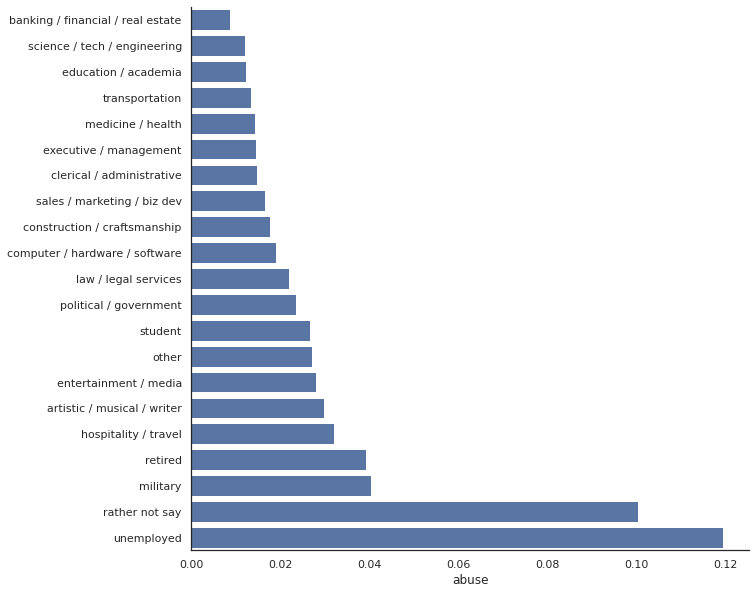

In [16]:
sns.set_style("white")
plt.figure(figsize=(10,10))
sns.barplot(x="abuse", y=job_relative.index, data=job_relative, orient="h", color="b")
plt.ylabel("")
sns.despine()
plt.show()

In [17]:
job_abs = df_dummy.groupby("job")['abuse'].sum().sort_values().to_frame()
job_abs

,abuse
job,
transportation,3
military,5
clerical / administrative,7
retired,8
political / government,10
construction / craftsmanship,11
banking / financial / real estate,12
law / legal services,18
unemployed,21


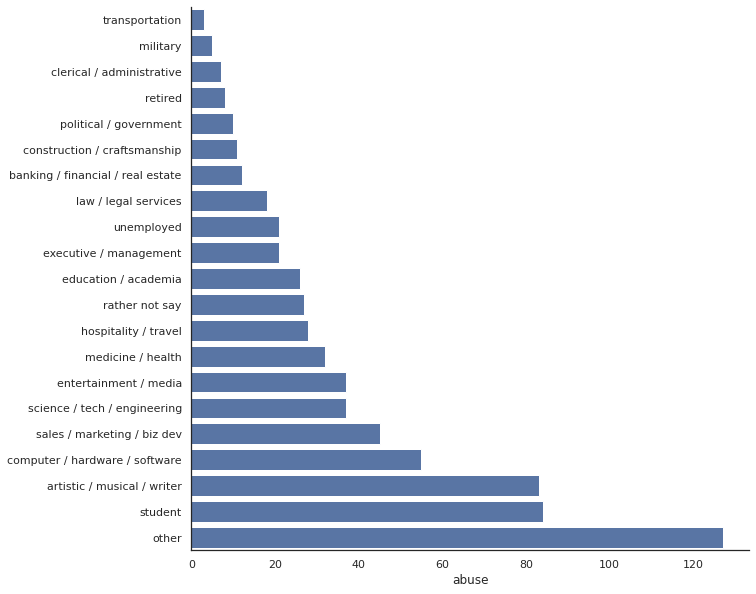

In [18]:
plt.figure(figsize=(10,10))
sns.barplot(x="abuse", y=job_abs.index, data=job_abs, orient="h", color="b")
plt.ylabel("")
sns.despine()
plt.show()

### Does having kids decrease the likelihood of substance abuse?

In [19]:
kids = df_dummy.dropna(axis=0, subset=["offspring"]).groupby("offspring")["abuse"].mean().to_frame()

In [20]:
kids.rename_axis("has kids")

,abuse
has kids,
0.0,0.024413
1.0,0.013984


### Does owning a pet help?

In [22]:
pets = df_dummy.groupby("has_pets")["abuse"].mean().to_frame()
pets

,abuse
has_pets,
False,0.020522
True,0.025656


0        False
1        False
2         True
3        False
5        False
         ...  
59936    False
59937    False
59942    False
59943    False
59944    False
Name: has_pets, Length: 35551, dtype: bool